## 데이터 로딩 및 전처리

In [1]:
import os
import urllib.request
import tarfile
import pickle
import numpy as np
from common.ResNet20 import ResNet20

def download_cifar100(save_path='cifar-100-python'):
    if os.path.exists(save_path):
        print("CIFAR-100 이미 존재")
        return

    url = 'https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz'
    filename = 'cifar-100-python.tar.gz'
    print("CIFAR-100 다운로드 중...")
    urllib.request.urlretrieve(url, filename)

    with tarfile.open(filename, 'r:gz') as tar:
        tar.extractall()
    os.remove(filename)
    print("다운로드 완료")

def load_batch(filepath):
    with open(filepath, 'rb') as f:
        data_dict = pickle.load(f, encoding='bytes')
    data = data_dict[b'data']
    fine_labels = np.array(data_dict[b'fine_labels'])
    coarse_labels = np.array(data_dict[b'coarse_labels'])
    data = data.reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
    return data, fine_labels, coarse_labels

def load_cifar100_full(data_dir='./cifar-100-python', valid_ratio=0.1):
    # 1. Load train and test batch
    x_train_all, y_train_fine_all, y_train_coarse_all = load_batch(os.path.join(data_dir, 'train'))
    x_test, y_test_fine, y_test_coarse = load_batch(os.path.join(data_dir, 'test'))

    # 2. Split train → train + validation
    num_total = x_train_all.shape[0]
    num_valid = int(num_total * valid_ratio)

    x_valid = x_train_all[:num_valid]
    t_valid_fine = y_train_fine_all[:num_valid]
    t_valid_coarse = y_train_coarse_all[:num_valid]

    x_train = x_train_all[num_valid:]
    t_train_fine = y_train_fine_all[num_valid:]
    t_train_coarse = y_train_coarse_all[num_valid:]

    # 3. Return all
    return (x_train, x_valid, x_test,
            t_train_coarse, t_valid_coarse, y_test_coarse,
            t_train_fine, t_valid_fine, y_test_fine)

In [2]:
# CIFAR-100 다운로드
download_cifar100()

# 전체 데이터셋 로드
(x_train, x_valid, x_test,
 t_train_coarse, t_valid_coarse, t_test_coarse,
 t_train_fine, t_valid_fine, t_test_fine) = load_cifar100_full()

# 확인 출력
print("CIFAR-100 데이터셋 로드 완료:")
print(" - x_train:", x_train.shape)
print(" - x_valid:", x_valid.shape)
print(" - x_test :", x_test.shape)
print(" - t_train_fine :", t_train_fine.shape)
print(" - t_valid_fine :", t_valid_fine.shape)
print(" - t_test_fine  :", t_test_fine.shape)
print(" - t_train_coarse:", t_train_coarse.shape)
print(" - t_valid_coarse:", t_valid_coarse.shape)
print(" - t_test_coarse :", t_test_coarse.shape)


CIFAR-100 이미 존재
CIFAR-100 데이터셋 로드 완료:
 - x_train: (45000, 3, 32, 32)
 - x_valid: (5000, 3, 32, 32)
 - x_test : (10000, 3, 32, 32)
 - t_train_fine : (45000,)
 - t_valid_fine : (5000,)
 - t_test_fine  : (10000,)
 - t_train_coarse: (45000,)
 - t_valid_coarse: (5000,)
 - t_test_coarse : (10000,)


## 모델 파라미터 불러오기

In [3]:
def restore_model_parameters(model, model_state):
    
    model.conv1.W = model_state['conv1_W']
    model.conv1.b = model_state['conv1_b']

    model.fc.W = model_state['fc_W']
    model.fc.b = model_state['fc_b']

    idx = 0
    for block in model.layer1 + model.layer2 + model.layer3:
        for attr in ['conv1', 'conv2', 'shortcut']:
            if hasattr(block, attr):
                conv = getattr(block, attr)
                conv.W = model_state[f'{idx}_W']
                conv.b = model_state[f'{idx}_b']
                idx += 1

def restore_bn_params(model, state):
    bn_count = 0
    for block in model.layer1 + model.layer2 + model.layer3:
        for attr in ['bn1', 'bn2']:
            bn = getattr(block, attr)
            bn.gamma = state[f'{bn_count}_gamma']
            bn.beta = state[f'{bn_count}_beta']
            bn.running_mean = state[f'{bn_count}_running_mean']
            bn.running_var = state[f'{bn_count}_running_var']
            bn_count += 1
        if hasattr(block, 'bn_shortcut'):
            bn = block.bn_shortcut
            bn.gamma = state[f'{bn_count}_gamma']
            bn.beta = state[f'{bn_count}_beta']
            bn.running_mean = state[f'{bn_count}_running_mean']
            bn.running_var = state[f'{bn_count}_running_var']
            bn_count += 1

    bn = model.bn1
    bn.gamma = state[f'{bn_count}_gamma']
    bn.beta = state[f'{bn_count}_beta']
    bn.running_mean = state[f'{bn_count}_running_mean']
    bn.running_var = state[f'{bn_count}_running_var']

In [4]:
from common.ResNet20 import ResNet20

model = ResNet20()

with open("final_parameters/crop_epoch_10.pkl", "rb") as f:
    checkpoint = pickle.load(f)
    model_state = checkpoint["model"]
    
restore_bn_params(model, model_state)
restore_model_parameters(model, model_state)

print("fc_W std:", np.std(model.fc.W))
print("fc_b std:", np.std(model.fc.b))
print("conv1_W std:", np.std(model.conv1.W))

fc_W std: 0.6059813480004459
fc_b std: 0.2697215860402543
conv1_W std: 0.6362145435582259


In [5]:
from common.functions import softmax  

def evaluate_model(model, x, y_true):
    batch_size = 100
    preds = []
    for i in range(0, x.shape[0], batch_size):
        x_batch = x[i:i+batch_size]
        logits = model.predict(x_batch)        
        probs = softmax(logits)                
        y_pred = np.argmax(probs, axis=1)
        preds.append(y_pred)
    preds = np.concatenate(preds)
    acc = np.sum(preds == y_true) / len(y_true)
    return preds, acc

#pred : 예측된 클래스 번호
#전체 정확도

In [6]:
def get_cifar100_fine_to_coarse_dict():
    """
    CIFAR-100 공식 fine label (0~99) → coarse label (0~19) 매핑 딕셔너리
    """
    fine_to_coarse = {
         4: 0, 30: 0, 55: 0, 72: 0, 95: 0,     # aquatic mammals
         1: 1, 32: 1, 67: 1, 73: 1, 91: 1,     # fish
        54: 2, 62: 2, 70: 2, 82: 2, 92: 2,     # flowers
        9: 3, 10: 3, 16: 3, 28: 3, 61: 3,      # food containers
         0: 4, 51: 4, 53: 4, 57: 4, 83: 4,     # fruit and vegetables
        22: 5, 39: 5, 40: 5, 86: 5, 87: 5,     # household electrical devices
         5: 6, 20: 6, 25: 6, 84: 6, 94: 6,     # household furniture
         6: 7, 7: 7, 14: 7, 18: 7, 24: 7,      # insects
        3: 8, 42: 8, 43: 8, 88: 8, 97: 8,      # large carnivores
        12: 9, 17: 9, 37: 9, 68: 9, 76: 9,     # large man-made outdoor things
        23:10, 33:10, 49:10, 60:10, 71:10,     # large natural outdoor scenes
        15:11, 19:11, 21:11, 31:11, 38:11,     # medium-sized mammals
        34:12, 63:12, 64:12, 66:12, 75:12,     # non-insect invertebrates
        26:13, 45:13, 77:13, 79:13, 99:13,     # people
         2:14, 11:14, 35:14, 46:14, 98:14,     # reptiles
         27:15, 29:15, 44:15, 78:15, 93:15,    # small mammals
         36:16, 50:16, 65:16, 74:16, 80:16,    # trees
         8:17, 13:17, 48:17, 58:17, 90:17,     # vehicles 1
        41:18, 52:18, 56:18, 59:18, 96:18,     # vehicles 2
        47:19, 69:19, 81:19, 85:19, 89:19      # objects
    }
    return fine_to_coarse



def map_softmax_to_coarse(softmax_output, fine_to_coarse):
    """
    softmax_output: shape (N, 100), softmax 확률 결과
    fine_to_coarse: dict, fine label → coarse label 매핑
    
    return: pred_coarse: shape (N,), coarse label 예측 결과
    """
    fine_pred = np.argmax(softmax_output, axis=1)  # shape (N,)
    coarse_pred = np.array([fine_to_coarse[f] for f in fine_pred])  # shape (N,)
    return coarse_pred

In [7]:
##이부분 코드는 앙상블 코드와 비슷하게 
#train data set
logits_train = model.predict(x_train)        
probs_train = softmax(logits_train)
preds_train_fine = np.argmax(probs_train, axis=1)
acc_train_fine = np.sum(preds_train_fine == t_train_fine) / len(t_train_fine)
print(f"[Fine Label] Train Accuracy: {acc_train_fine:.4f}")

#딕셔너리 매핑 후 coarse 정확도
fine_to_coarse = get_cifar100_fine_to_coarse_dict()
preds_train_coarse = map_softmax_to_coarse(probs_train, fine_to_coarse)
acc_train_coarse = np.mean(preds_train_coarse == t_train_coarse)
print(f"[Coarse Label] Ensemble Accuracy: {acc_train_coarse:.4f}")

[Fine Label] Train Accuracy: 0.5412
[Coarse Label] Ensemble Accuracy: 0.5850


In [8]:
#valid data set
logits_valid = model.predict(x_valid)        
probs_valid = softmax(logits_valid)
preds_valid_fine = np.argmax(probs_valid, axis=1)
acc_valid_fine = np.sum(preds_valid_fine == t_valid_fine) / len(t_valid_fine)
print(f"[Fine Label] Valid Accuracy: {acc_valid_fine:.4f}")

#딕셔너리 매핑 후 coarse 정확도
fine_to_coarse = get_cifar100_fine_to_coarse_dict()
preds_valid_coarse = map_softmax_to_coarse(probs_valid, fine_to_coarse)
acc_valid_coarse = np.mean(preds_valid_coarse == t_valid_coarse)
print(f"[Coarse Label] Valid Accuracy: {acc_valid_coarse:.4f}")

[Fine Label] Valid Accuracy: 0.5408
[Coarse Label] Valid Accuracy: 0.5808


In [10]:
#Test data set
logits_test = model.predict(x_test)        
probs_test = softmax(logits_test)
preds_test_fine = np.argmax(probs_test, axis=1)
acc_test_fine = np.sum(preds_test_fine == t_test_fine) / len(t_test_fine)
print(f"[Fine Label] Valid Accuracy: {acc_test_fine:.4f}")

#딕셔너리 매핑 후 coarse 정확도
fine_to_coarse = get_cifar100_fine_to_coarse_dict()
preds_test_coarse = map_softmax_to_coarse(probs_test, fine_to_coarse)
acc_test_coarse = np.mean(preds_test_coarse == t_test_coarse)
print(f"[Coarse Label] Valid Accuracy: {acc_test_coarse:.4f}")

[Fine Label] Valid Accuracy: 0.4826
[Coarse Label] Valid Accuracy: 0.5379


## 모델 성능 분석

### 1. confusion matrix

In [11]:
def compute_confusion_matrix(y_true, y_pred, num_classes): #정답, 예측 쌍.-> 둘 다 argmax
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

def plot_confusion_matrix(cm, class_labels=None, title='Confusion Matrix', normalize=False):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        cm = np.nan_to_num(cm)  # 0으로 나누는 경우 방지

    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(cm, cmap='Blues')
    fig.colorbar(cax)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title(title)

    if class_labels is not None:
        ax.set_xticks(np.arange(len(class_labels)))
        ax.set_yticks(np.arange(len(class_labels)))
        ax.set_xticklabels(class_labels, rotation=90)
        ax.set_yticklabels(class_labels)

    plt.tight_layout()
    plt.show()


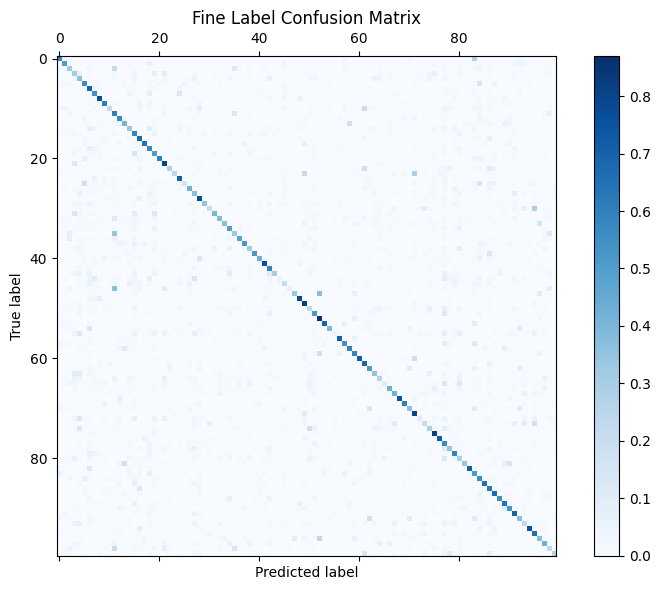

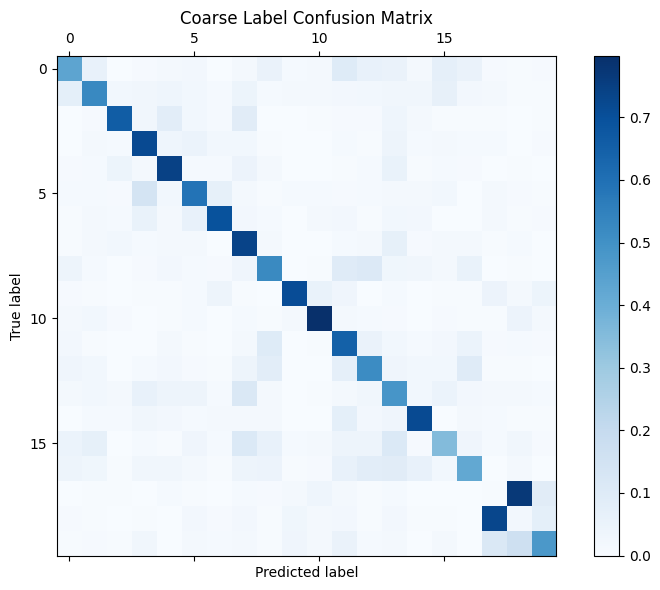

In [13]:
import matplotlib.pyplot as plt
import numpy as np  # 혹시 안 했다면 이것도 필요

# test data confusion matrix
cm = compute_confusion_matrix(t_test_fine, preds_test_fine, num_classes=100)
plot_confusion_matrix(cm, title="Fine Label Confusion Matrix", normalize=True)

# test data confusion matrix
cm = compute_confusion_matrix(t_test_coarse, preds_test_coarse, num_classes=20)
plot_confusion_matrix(cm, title="Coarse Label Confusion Matrix", normalize=True)

In [16]:
def get_coarse_to_fine():
    return {
        0: [4, 30, 55, 72, 95],
        1: [1, 32, 67, 73, 91],
        2: [54, 62, 70, 82, 92],
        3: [9, 10, 16, 28, 61],
        4: [0, 51, 53, 57, 83],
        5: [22, 39, 40, 86, 87],
        6: [5, 20, 25, 84, 94],
        7: [6, 7, 14, 18, 24],
        8: [3, 42, 43, 88, 97],
        9: [12, 17, 37, 68, 76],
        10: [23, 33, 49, 60, 71],
        11: [15, 19, 21, 31, 38],
        12: [34, 63, 64, 66, 75],
        13: [26, 45, 77, 79, 99],
        14: [2, 11, 35, 46, 98],
        15: [27, 29, 44, 78, 93],
        16: [36, 50, 65, 74, 80],
        17: [8, 13, 48, 58, 90],
        18: [41, 52, 56, 59, 96],
        19: [47, 69, 81, 85, 89],
    }


def plot_fine_confusion_subset(t_true, t_pred, fine_labels_subset, title='Subset Fine Confusion'):
    idx = [i for i in range(len(t_true)) if t_true[i] in fine_labels_subset and t_pred[i] in fine_labels_subset]
    t_sub = [t_true[i] for i in idx]
    p_sub = [t_pred[i] for i in idx]

    fine_label_map = {label: i for i, label in enumerate(fine_labels_subset)}
    t_sub_mapped = [fine_label_map[t] for t in t_sub]
    p_sub_mapped = [fine_label_map[p] for p in p_sub]

    cm = compute_confusion_matrix(t_sub_mapped, p_sub_mapped, num_classes=len(fine_labels_subset))
    plot_confusion_matrix(cm, class_labels=[str(l) for l in fine_labels_subset],
                          title=title, normalize=True)

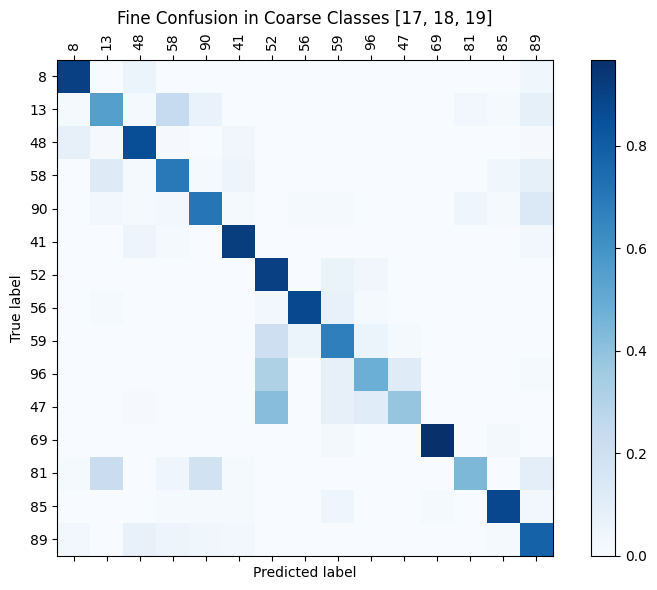

In [21]:
selected_coarse_ids = [17, 18, 19] #coarse class 선택
coarse_to_fine = get_coarse_to_fine()
selected_fine_labels = []
for cid in selected_coarse_ids:
    selected_fine_labels.extend(coarse_to_fine[cid])

plot_fine_confusion_subset(t_test_fine, preds_test_fine,
                           fine_labels_subset=selected_fine_labels,
                           title=f"Fine Confusion in Coarse Classes {selected_coarse_ids}")


### 2. 시각화 함수

In [48]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_samples_grid(x_samples, true_fine, pred_fine, true_coarse, pred_coarse,
                           title="Sample Predictions", num_show=30, cols=10):
    """
    여러 이미지를 그리드 형태(여러 행)로 시각화
    """
    rows = (num_show + cols - 1) // cols  # 행 수 자동 계산

    plt.figure(figsize=(cols * 2, rows * 2.5))
    for i in range(num_show):
        plt.subplot(rows, cols, i + 1)
        img = x_samples[i].transpose(1, 2, 0)  # (C, H, W) → (H, W, C)
        plt.imshow(img)
        plt.axis('off')

        # 예측 정보
        plt.text(16, -5, f"Fine: {true_fine[i]}→{pred_fine[i]}", color='red',
                 fontsize=7, ha='center', transform=plt.gca().transData)
        plt.text(16, -2, f"Coarse: {true_coarse[i]}→{pred_coarse[i]}", color='blue',
                 fontsize=7, ha='center', transform=plt.gca().transData)

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


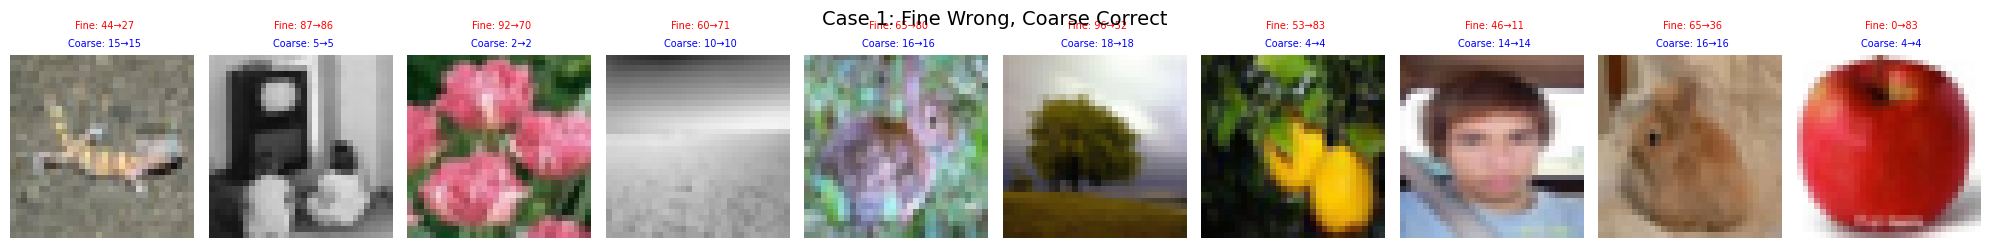

In [52]:
# fine / coarse 예측
fine_preds = np.argmax(probs_test, axis=1)
true_coarse = np.array([fine_to_coarse[f] for f in t_test_fine])
coarse_preds = np.array([fine_to_coarse[f] for f in fine_preds])

# --- 케이스 정의 ---
case1_idx = np.where((fine_preds != t_test_fine) & (coarse_preds == true_coarse))[0]  # fine 틀림, coarse 맞음
case2_idx = np.where((fine_preds == t_test_fine) & (coarse_preds != true_coarse))[0]  # fine 맞음, coarse 틀림

# --- 샘플 선택 (case1 예시) ---
num_samples = min(10, len(case1_idx))  # 10개 이하일 수 있음
idx = np.random.choice(case1_idx, num_samples, replace=False)

# --- 데이터 추출 ---
x_sample = x_test[idx]
t_fine = t_test_fine[idx]
p_fine = fine_preds[idx]
t_coarse = true_coarse[idx]
p_coarse = coarse_preds[idx]

# --- 시각화 ---
visualize_samples_grid(x_sample, t_fine, p_fine, t_coarse, p_coarse,
                  title="Case 1: Fine Wrong, Coarse Correct", num_show=num_samples,cols=10)


In [36]:
# --- 샘플 선택 (case2 예시) ---
num_samples = min(10, len(case2_idx))  # 10개 이하일 수 있음
idx = np.random.choice(case2_idx, num_samples, replace=False)

# --- 데이터 추출 ---
x_sample = x_test[idx]
t_fine = t_test_fine[idx]
p_fine = fine_preds[idx]
t_coarse = true_coarse[idx]
p_coarse = coarse_preds[idx]

# --- 시각화 ---
visualize_samples(x_sample, t_fine, p_fine, t_coarse, p_coarse,
                  title="Case 2: Fine Correct, Coarse Wrong", num_show=num_samples)



<Figure size 0x300 with 0 Axes>

In [38]:
# confusion matrix (raw count 또는 normalized 모두 가능)
cm_coarse = compute_confusion_matrix(t_test_coarse, preds_test_coarse, num_classes=20)

# 오분류율 = 전체 - 정답 / 전체
misclass_rate = 1 - np.diag(cm_coarse) / np.sum(cm_coarse, axis=1)
misclass_rate = np.nan_to_num(misclass_rate)

# 상위 N개 coarse class 인덱스 추출 (예: 3개)
top_k = 3
worst_coarse_ids = np.argsort(misclass_rate)[-top_k:]
print("오분류율 높은 coarse class:", worst_coarse_ids)

error_idx = []
for c in worst_coarse_ids:
    idx = np.where((t_test_coarse == c) & (preds_test_coarse != c))[0]
    error_idx.extend(idx)

error_idx = np.array(error_idx)

오분류율 높은 coarse class: [15 18 17]


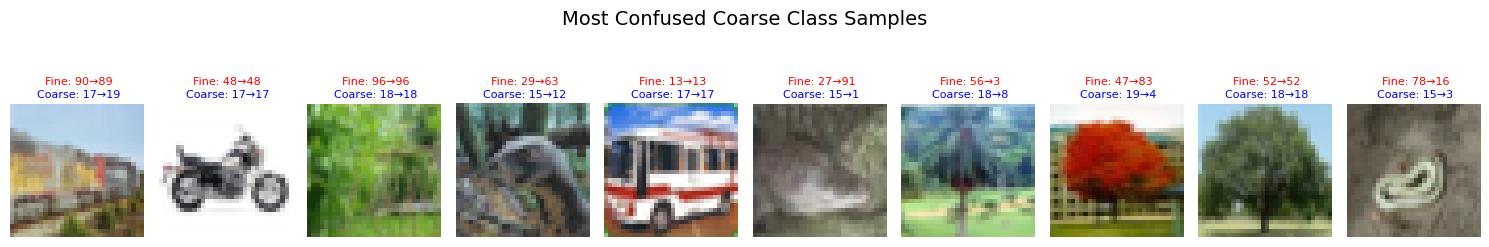

In [41]:
# 샘플 추출
num_samples = min(10, len(error_idx))
selected_idx = np.random.choice(error_idx, num_samples, replace=False)

# 데이터 추출
x_sample = x_test[selected_idx]
t_fine = t_test_fine[selected_idx]
p_fine = fine_preds[selected_idx]
t_coarse = np.array([fine_to_coarse[f] for f in t_fine])
p_coarse = np.array([fine_to_coarse[f] for f in p_fine])

# 시각화
visualize_samples(x_sample, t_fine, p_fine, t_coarse, p_coarse,
                  title=f"Most Confused Coarse Class Samples", num_show=num_samples)
